<a href="https://colab.research.google.com/github/naavsaa/Hactiv8-Python/blob/master/Hactiv8/PYTN_Assgn_2_Batch_062_Maruli_Asvan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import scipy.stats
from scipy.stats import uniform
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read Data

In [2]:
# When using data from Gdrive
from google.colab import drive   
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/Dataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Dataset


In [3]:
df=pd.read_csv('nyc-rolling-sales.csv')

In [4]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


# Data Cleansing 

In [5]:
# replace field that's entirely space (or empty) with NaN
(df.replace(r'^\s*$', np.nan, regex=True, inplace=True))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      84548 non-null  int64  
 1   BOROUGH                         84548 non-null  int64  
 2   NEIGHBORHOOD                    84548 non-null  object 
 3   BUILDING CLASS CATEGORY         84548 non-null  object 
 4   TAX CLASS AT PRESENT            83810 non-null  object 
 5   BLOCK                           84548 non-null  int64  
 6   LOT                             84548 non-null  int64  
 7   EASE-MENT                       0 non-null      float64
 8   BUILDING CLASS AT PRESENT       83810 non-null  object 
 9   ADDRESS                         84548 non-null  object 
 10  APARTMENT NUMBER                19052 non-null  object 
 11  ZIP CODE                        84548 non-null  int64  
 12  RESIDENTIAL UNITS               

In [7]:
# Drop Unnamed: 0 and EASE-MENT
df.drop(columns={'Unnamed: 0', 'EASE-MENT'}, inplace=True) 

In [8]:
# Drop column address and apartment number as it will not be use for analysis
df.drop(columns={'ADDRESS', 'APARTMENT NUMBER'}, axis=1, inplace=True)

In [9]:
# Change some column type from string to float
floats = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']
for col in floats:
    df[col]=pd.to_numeric(df[col], errors='coerce')

In [10]:
# Change some column type as category
categoricals = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
                'BUILDING CLASS AT PRESENT']

for col in categoricals:
    df[col] = df[col].astype('category')

In [11]:
#Change SALE DATE column typ to datetime dtype and
# Split 'SALE DATE' into month and year
df['SALE DATE']= pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE MONTH'] = pd.DatetimeIndex(df['SALE DATE']).month
df['SALE YEAR'] = pd.DatetimeIndex(df['SALE DATE']).year
df.drop('SALE DATE', axis=1, inplace=True)

count    84548.000000
mean         2.249184
std         18.972584
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2261.000000
Name: TOTAL UNITS, dtype: float64

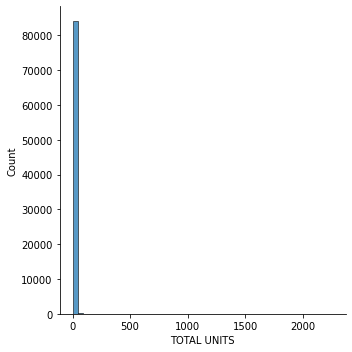

In [12]:
# Check Total Unit
sns.displot(df['TOTAL UNITS'], bins=50)
df['TOTAL UNITS'].describe()

In [13]:
# Delete row with value 0 in total unit column and maximum total unit is 2261 which is doesnt make any sense where in one sale there is purchase of 2261 unit

df = df[(df['TOTAL UNITS'] > 0) & (df['TOTAL UNITS'] != 2261)]

<Figure size 864x360 with 0 Axes>

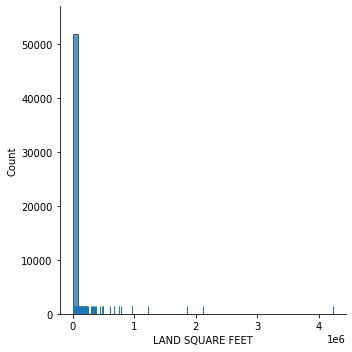

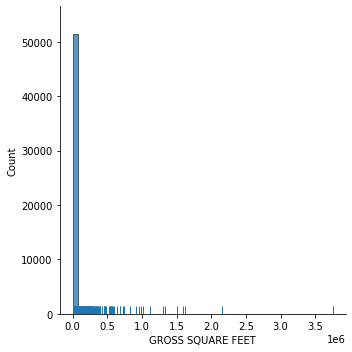

In [14]:
# Check Land Square and Gross Square
plt.figure(figsize=(12,5))
sns.displot(df['LAND SQUARE FEET'], bins=50, rug=True)
sns.displot(df['GROSS SQUARE FEET'], bins=50, rug=True)
plt.show()

In [15]:
# Delete row with value 0 in land square and gross square column
# df = df[df['LAND SQUARE FEET']!=0]
# df = df[df['GROSS SQUARE FEET']!=0]
df = df[(df['LAND SQUARE FEET'] > 0) & (df['LAND SQUARE FEET'] < 10000)]
df = df[(df['GROSS SQUARE FEET'] > 0) & (df['GROSS SQUARE FEET'] < 10000)]

<Figure size 864x360 with 0 Axes>

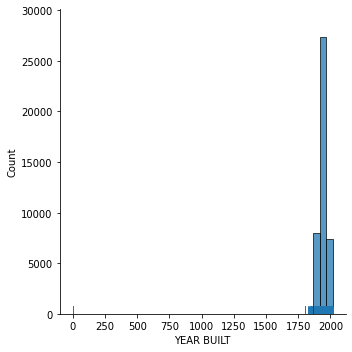

In [16]:
# Check Year Built
plt.figure(figsize=(12,5))
sns.displot(df['YEAR BUILT'], bins=40, rug=True)
plt.show()

In [17]:
df = df[df['YEAR BUILT']!=0]

<Figure size 864x360 with 0 Axes>

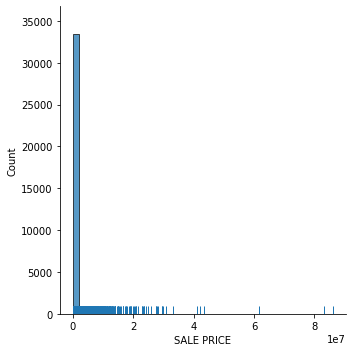

In [18]:
# Check Sale Price Data
plt.figure(figsize=(12,5))
sns.displot(df['SALE PRICE'], bins=40, rug=True)
plt.show()

In [19]:
df['SALE PRICE'][df['SALE PRICE']>5000000].count()

395

In [20]:
# There are alot of $0 or small amount of Price that refer to transfer of deeds between parties.
# Assume Value Less than $10K is all counted as transfer of deeds, thus this rows will be deleted
# Assume value above $5M is also dropped
df = df[df['SALE PRICE'].between(10000, 5000000)]


In [21]:
# Check Sale Year Data
df['SALE YEAR'].value_counts()

2017    17204
2016     9357
Name: SALE YEAR, dtype: int64

Data after Cleansing that will be used for analysis

In [22]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE MONTH,SALE YEAR
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,9,2016
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,9,2016
172,1,ALPHABET CITY,14 RENTALS - 4-10 UNIT,2A,391,19,S3,10009,3,1,4,1520.0,3360.0,1910,2,S3,3300000.0,11,2016
174,1,ALPHABET CITY,14 RENTALS - 4-10 UNIT,2A,394,5,S5,10009,5,1,6,1779.0,3713.0,1910,2,S5,4750000.0,4,2017
195,1,ALPHABET CITY,22 STORE BUILDINGS,4,390,34,K4,10009,0,1,1,1218.0,3586.0,1899,4,K4,3700000.0,9,2016


In [23]:
print("unique value in Borough:",len(df['BOROUGH'].unique()))
print("unique value in NEIGHBORHOOD:",len(df['NEIGHBORHOOD'].unique()))
print("unique value in BUILDING CLASS CATEGORY:",len(df['TAX CLASS AT PRESENT'].unique()))
print("unique value in TAX CLASS AT PRESENT:",len(df['BOROUGH'].unique()))
print("unique value in BLOCK:",len(df['BLOCK'].unique()))
print("unique value in BUILDING CLASS AT PRESENT:",len(df['BUILDING CLASS AT PRESENT'].unique()))
print("unique value in ZIP CODE:",len(df['ZIP CODE'].unique()))
print("unique value in YEAR BUILT:",len(df['YEAR BUILT'].unique()))
print("unique value in TAX CLASS AT TIME OF SALE:",len(df['TAX CLASS AT TIME OF SALE'].unique()))
print("unique value in BUILDING CLASS AT TIME OF SALE:",len(df['BUILDING CLASS AT TIME OF SALE'].unique()))


unique value in Borough: 5
unique value in NEIGHBORHOOD: 236
unique value in BUILDING CLASS CATEGORY: 6
unique value in TAX CLASS AT PRESENT: 5
unique value in BLOCK: 9534
unique value in BUILDING CLASS AT PRESENT: 86
unique value in ZIP CODE: 167
unique value in YEAR BUILT: 130
unique value in TAX CLASS AT TIME OF SALE: 3
unique value in BUILDING CLASS AT TIME OF SALE: 88


#Data Analysis 

In [24]:
# Statistic for Total Unit
mean_totalunit = stats.mean(df['TOTAL UNITS']) #Mean
print ("Rata-rata total unit terjual 2016-2017:" , round(mean_totalunit,2),"unit")

harmonic_mean_totalunit = stats.harmonic_mean(df['TOTAL UNITS']) #Harmonic Mean
print ("Rata-rata harmonic dari total unit terjual 2016-2017:" , round(harmonic_mean_totalunit,2))

median_totalunit = stats.median(df['TOTAL UNITS']) #Median
print ("Nilai tengah total unit terjual 2016-2017:" , median_totalunit,"unit")

mode_totalunit = stats.mode(df['TOTAL UNITS']) #Mode
print ("Total unit yang sering terjual 2016-2017:" , mode_totalunit,"unit")

variance_totalunit = round(stats.variance(df['TOTAL UNITS']),3) #Variance
std_totalunit = round(stats.stdev(df['TOTAL UNITS']),3) #Standard Deviation
print ("Variance dari total unit adalah:" , variance_totalunit, "dengan standard deviasi:", std_totalunit)

skew_totalunit = round(scipy.stats.skew(df['TOTAL UNITS'], bias=False),3) #Skewness
print("Skewness dari total unit adalah:", skew_totalunit)

min_totalunit= min(df['TOTAL UNITS']) #Range
max_totalunit= max(df['TOTAL UNITS'])
print("Range dari total unit yang terjual adalah:",min_totalunit,"-",max_totalunit,"unit")

Rata-rata total unit terjual 2016-2017: 1.86 unit
Rata-rata harmonic dari total unit terjual 2016-2017: 1.43
Nilai tengah total unit terjual 2016-2017: 2 unit
Total unit yang sering terjual 2016-2017: 1 unit
Variance dari total unit adalah: 1.683 dengan standard deviasi: 1.297
Skewness dari total unit adalah: 3.678
Range dari total unit yang terjual adalah: 1 - 20 unit


In [25]:
# Statistic for Sale Price
mean_saleprice = stats.mean(df['SALE PRICE']) #Mean
print ("rata-rata harga jual terjual 2016-2017:" , round(mean_saleprice/1000,2),"K USD")

harmonic_mean_saleprice = stats.harmonic_mean(df['SALE PRICE']) #Harmonic Mean
print ("rata-rata harmonic dari harga jual terjual 2016-2017:" , round(harmonic_mean_saleprice/1000,2),"K USD")

median_saleprice = stats.median(df['SALE PRICE']) #Median
print ("nilai tengah harga jual terjual 2016-2017:" , median_saleprice,"USD")

mode_saleprice = stats.mode(df['SALE PRICE']) #Mode
print ("harga unit yang sering terjual 2016-2017:" , mode_saleprice,"USD")

variance_saleprice = round(stats.variance(df['SALE PRICE']),3) #Variance
std_saleprice = round(stats.stdev(df['SALE PRICE']),3) #Standard Deviation
print ("Variance dari harga jual adalah:" , variance_saleprice, "dengan standard deviasi:", std_saleprice)

skew_saleprice = round(scipy.stats.skew(df['SALE PRICE'], bias=False),3) #Skewness
print("Skewness dari harga jual adalah:", skew_totalunit)

min_saleprice= min(df['SALE PRICE']) #Range
max_saleprice= max(df['SALE PRICE'])
print("Range dari harga jual adalah:",min_totalunit,"-",max_totalunit,"USD")

rata-rata harga jual terjual 2016-2017: 769.53 K USD
rata-rata harmonic dari harga jual terjual 2016-2017: 416.71 K USD
nilai tengah harga jual terjual 2016-2017: 607000.0 USD
harga unit yang sering terjual 2016-2017: 700000.0 USD
Variance dari harga jual adalah: 367889513892.272 dengan standard deviasi: 606538.963
Skewness dari harga jual adalah: 3.678
Range dari harga jual adalah: 1 - 20 USD


In [26]:
# Statistic for Land Square Feet
mean_landsquare = stats.mean(df['LAND SQUARE FEET']) #Mean
print ("rata-rata ukuran bangunan terjual 2016-2017:" , round(mean_landsquare,2),"Sq Ft")

harmonic_mean_landsquare = stats.harmonic_mean(df['LAND SQUARE FEET']) #Harmonic Mean
print ("rata-rata harmonic ukuran bangunan terjual 2016-2017:" , round(harmonic_mean_landsquare,2),"Sq Ft")

median_landsquare = stats.median(df['LAND SQUARE FEET'])#Median
print ("nilai tengah ukuran bangunan terjual 2016-2017:" , median_landsquare,"Sq Ft")

mode_landsquare = stats.mode(df['LAND SQUARE FEET']) #Mode
print ("ukuran bangunan yang sering terjual 2016-2017:" , mode_landsquare,"Sq Ft")

variance_landsquare = round(stats.variance(df['LAND SQUARE FEET']),3) #Variance
std_landsquare = round(stats.stdev(df['LAND SQUARE FEET']),3) #Standard Deviation
print ("Variance dari ukuran bangunan adalah:" , variance_landsquare, "dengan standard deviasi:", std_landsquare)

skew_landsquare = round(scipy.stats.skew(df['LAND SQUARE FEET'], bias=False),3) #Skewness
print("Skewness dari ukuran bangunan adalah:", skew_totalunit)

min_landsquare= min(df['LAND SQUARE FEET']) #Range
max_landsquare= max(df['LAND SQUARE FEET'])
print("Range dari ukuran bangunan adalah:",min_totalunit,"-",max_totalunit,"Sq Ft")

rata-rata ukuran bangunan terjual 2016-2017: 2901.79 Sq Ft
rata-rata harmonic ukuran bangunan terjual 2016-2017: 2399.47 Sq Ft
nilai tengah ukuran bangunan terjual 2016-2017: 2500.0 Sq Ft
ukuran bangunan yang sering terjual 2016-2017: 2000.0 Sq Ft
Variance dari ukuran bangunan adalah: 1910332.704 dengan standard deviasi: 1382.148
Skewness dari ukuran bangunan adalah: 3.678
Range dari ukuran bangunan adalah: 1 - 20 Sq Ft


In [27]:
# Statistic for NEIGHBORHOOD
mode_neighborhood = stats.mode(df['NEIGHBORHOOD'])



***Summary of Statsistic ***

In [28]:

stats_residantialunit= scipy.stats.describe(df['TOTAL UNITS'],bias=False)
stats_commercialunit= scipy.stats.describe(df['COMMERCIAL UNITS'],bias=False)
stats_totalunit= scipy.stats.describe(df['TOTAL UNITS'],bias=False)
stats_landsquare= scipy.stats.describe(df['LAND SQUARE FEET'],bias=False)
stats_grosssquare= scipy.stats.describe(df['GROSS SQUARE FEET'],bias=False)
stats_yearbuilt= scipy.stats.describe(df['YEAR BUILT'],bias=False)
stats_saleprice= scipy.stats.describe(df['SALE PRICE'],bias=False)


In [29]:
pd_stats_residantialunit = pd.DataFrame([stats_residantialunit], columns=stats_residantialunit._fields)
pd_stats_commercialunit = pd.DataFrame([stats_commercialunit], columns=stats_commercialunit._fields)
pd_stats_totalunit = pd.DataFrame([stats_totalunit], columns=stats_totalunit._fields)
pd_stats_landsquare = pd.DataFrame([stats_landsquare], columns=stats_landsquare._fields)
pd_stats_grosssquare = pd.DataFrame([stats_grosssquare], columns=stats_grosssquare._fields)
pd_stats_yearbuilt = pd.DataFrame([stats_yearbuilt], columns=stats_yearbuilt._fields)
pd_stats_saleprice = pd.DataFrame([stats_saleprice], columns=stats_saleprice._fields)
summary_stats= pd.concat([pd_stats_residantialunit, pd_stats_commercialunit,pd_stats_totalunit,pd_stats_landsquare,pd_stats_grosssquare,pd_stats_yearbuilt,pd_stats_saleprice])
summary_stats.rename({'nobs':'Number of Sample'}, axis=1, inplace=True)

index_list= ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS','TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT', 'SALE PRICE'] 
summary_stats['']=index_list
summary_stats.set_index('',inplace=True)


In [30]:
summary_stats_T=summary_stats.transpose()
print ("Summary of some column of NYC Property Sales are listed in table below")
summary_stats_T

Summary of some column of NYC Property Sales are listed in table below


,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
Number of Sample,26561,26561,26561,26561,26561,26561,26561
minmax,"(1, 20)","(0, 14)","(1, 20)","(200.0, 9996.0)","(120.0, 9926.0)","(1800, 2017)","(10000.0, 5000000.0)"
mean,1.85671,0.0873085,1.85671,2901.79,2074.86,1940.95,769533
variance,1.68316,0.16877,1.68316,1.91033e+06,1.23273e+06,918.697,3.6789e+11
skewness,3.67783,8.92452,3.67783,1.60547,2.353,0.808583,2.86376
kurtosis,22.6742,140.806,22.6742,3.31876,8.73945,-0.0600706,11.325


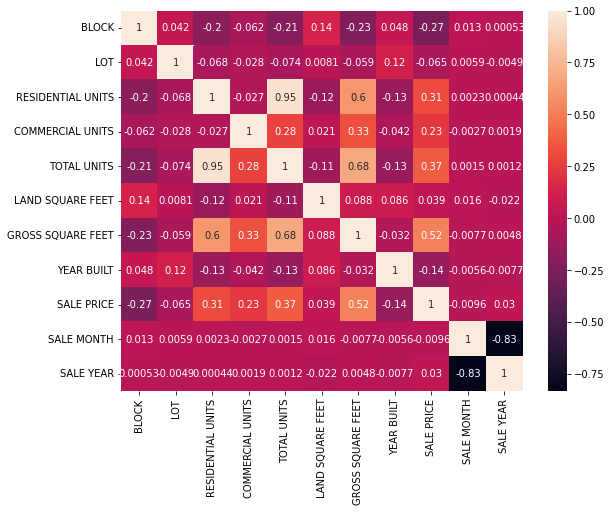

In [31]:
#Check Correlation of all Parameter
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_corr, annot=True)

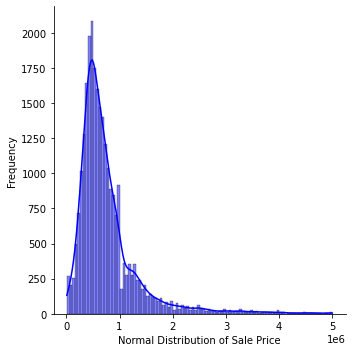

In [32]:
# Normal Distribution for Sale Price
norm_saleprice= sns.displot(df['SALE PRICE'], bins=100, kde=True,color='blue')
norm_saleprice.set(xlabel="Normal Distribution of Sale Price", ylabel="Frequency")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


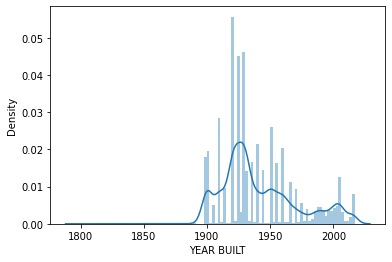

In [33]:
# Distribution of Year Built
sns.distplot(df['YEAR BUILT'], bins=100)

In [34]:
# Hypotesis Testing
# Manhattan is said the most popular neighborhoods in NYC. The Hypotesis is Manhattan Much More Expensive than other Neighborhoods 

In [35]:
# Check unique value in borough column
df['BOROUGH'].value_counts()

4    10496
3     7971
5     4686
2     3139
1      269
Name: BOROUGH, dtype: int64

From google search, below is the borough number 

1 = Manhattan
2 = Bronx
3 = Brooklyn
4 = Queens
5 = Staten Island

In [36]:
df_manhattan=df[df.BOROUGH == 1]
df_others=df[df.BOROUGH != 1]

In [37]:
μ_manhattan_saleprice= stats.mean(df_manhattan['SALE PRICE']/df_manhattan['GROSS SQUARE FEET'])
μ_others_saleprice = stats.mean(df_others['SALE PRICE']/df_others['GROSS SQUARE FEET'])
n_manhattan=len(df[df['BOROUGH']==1])
n_others=len(df[df['BOROUGH']!=1])
μ_manhattan_stdev= stats.stdev(df_manhattan['SALE PRICE']/df_manhattan['GROSS SQUARE FEET'])
μ_others_stdev= stats.stdev(df_others['SALE PRICE']/df_others['GROSS SQUARE FEET'])

In [38]:
print("μ_manhattan_saleprice=",round(μ_manhattan_saleprice,2),"USD/Sq Feet")
print("μ_other_saleprice=",round(μ_others_saleprice,2),"USD/Sq Feet")

print("standard deviasi manhattan_saleprice=",round(μ_manhattan_stdev,2),"USD/Sq Feet")
print("standard deviasi others_saleprice=",round(μ_others_stdev,2),"USD/Sq Feet")

print("jumlah sample manhattan=",n_manhattan)
print("jumlah sample other borough=",n_others)

μ_manhattan_saleprice= 710.56 USD/Sq Feet
μ_other_saleprice= 388.42 USD/Sq Feet
standard deviasi manhattan_saleprice= 899.61 USD/Sq Feet
standard deviasi others_saleprice= 254.55 USD/Sq Feet
jumlah sample manhattan= 269
jumlah sample other borough= 26292


In [39]:
sm.stats.ztest((df_manhattan['SALE PRICE']/df_manhattan['GROSS SQUARE FEET']).dropna(),(df_others['SALE PRICE']/df_others['GROSS SQUARE FEET']).dropna(),alternative='two-sided')

(19.54901620352463, 4.205526732986334e-85)

Karena nilai p-value sangat kecil = 4,2e-85 maka kita dapat **Reject the Null Hypotesis**

 **Relationship of Unit and Sale Price**

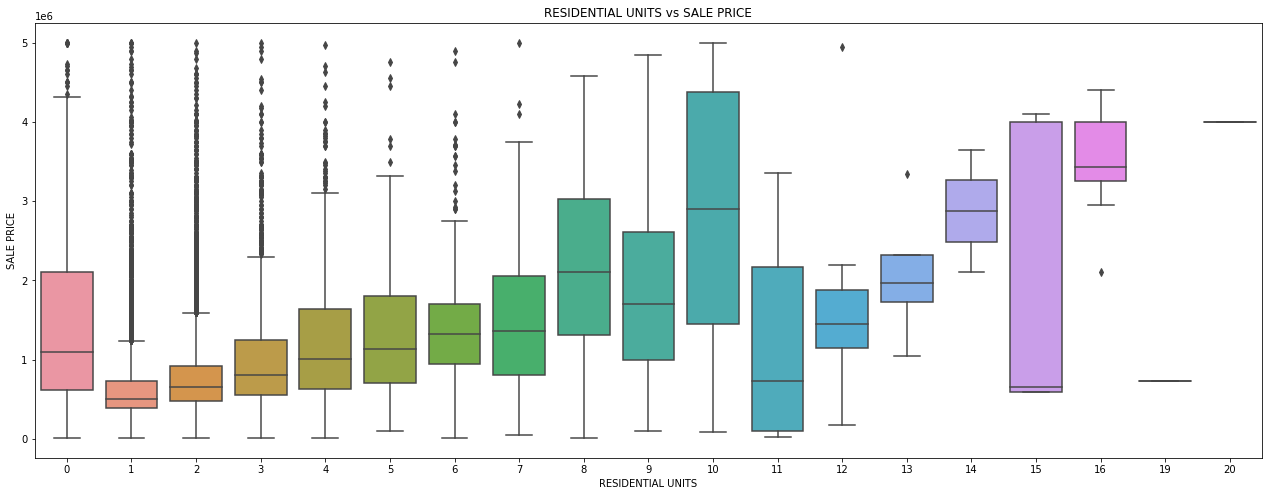

In [40]:
#Check Relationship between Residential Unit and Sale Price
plt.figure(figsize=(22,8))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df)
plt.title('RESIDENTIAL UNITS vs SALE PRICE')
plt.show()

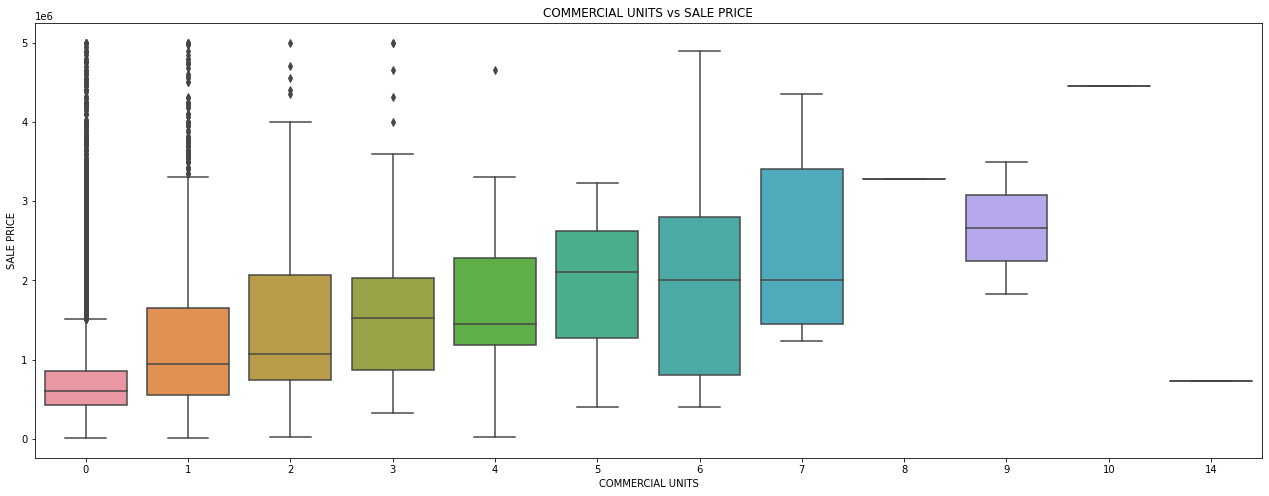

In [41]:
#Check Relationship between Commercial Unit and Sale Price
plt.figure(figsize=(22,8))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=df)
plt.title('COMMERCIAL UNITS vs SALE PRICE')
plt.show()

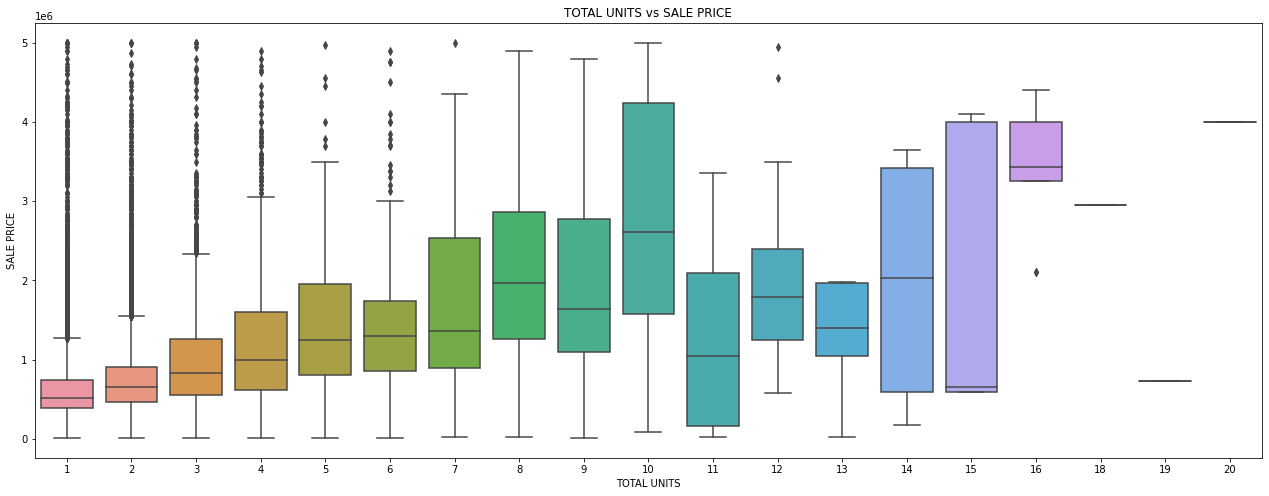

In [42]:
#Check Relationship between Total Unit and Sale Price
plt.figure(figsize=(22,8))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=df)
plt.title('TOTAL UNITS vs SALE PRICE')
plt.show()